# <font color='red'>CS235 Methods Project - Part 3 - Unsupervised Techniques</font>
### <font color='red'>Student: Prakash Perimbeti</font>
### <font color='red'>Student Id: 862545992</font>

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [30]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#  <font color='blue'>This entire preprocessing step is critical for:</font>
#### A. Efficient training of your CNN model.
#### B. Ensuring that the model only learns from digits 0–4 (Dataset A).
#### C. Setting up a consistent pipeline for training and validation.

## <font color='blue'>Step wise section of code details</font>
### 1. Set Random Seeds
- Ensures reproducibility of results.
- Fixes the random number generators in both NumPy and PyTorch to a known state (42), so that the same random choices (like dataset splits, weight initializations) occur each time you run the code.
### 2. Define Data Transformation
- Converts the MNIST images (PIL format) into PyTorch tensors.
- Normalization is not explicitly applied here; just raw pixel values scaled to 0, 1
### 3. Load MNIST Dataset
- Downloads and loads the training portion of the MNIST dataset.
- Applies the transformation (ToTensor()).
- Stores data in ./data directory.
### 4. Filter Digits 0–4
- Selects only the samples where the label is less than 5, i.e., digits 0, 1, 2, 3, 4.
- Creates a filtered subset of the dataset containing only these digits.
### 5. Split into Train/Test Sets (80/20)
- Splits the filtered subset into 80% training and 20% test data.
- random_split performs the split randomly (but deterministically because of the set seed).
### 6. Create Data Loaders
- Wraps the datasets in PyTorch DataLoaders for efficient batching and shuffling:
- train_loader: Loads batches of 64 samples, shuffles data at each epoch.
- test_loader: Loads batches of 64 samples, does not shuffle (important for consistent evaluation).

In [32]:

# Set seeds
np.random.seed(42)
torch.manual_seed(42)

# Load MNIST dataset (digits 0–4 only)
transform = transforms.Compose([transforms.ToTensor()])
#mnist_full = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
mnist_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Access the data and check its shape
data_shape = mnist_full.data.shape
print(f"MNIST Data shape: {data_shape}")
indices = [i for i, (img, label) in enumerate(mnist_full) if label < 5]
subset = Subset(mnist_full, indices)

# Split 80/20
train_size = int(0.8 * len(subset))
val_size = len(subset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(subset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

MNIST Data shape: torch.Size([60000, 28, 28])


# <font color='blue'>Class SimpleCNN class encapsulates CNN architecture with three simple functions</font>
## 1. \_\_init\_\_(): 
- Initializes the CNN architecture with convolutional layers, activation functions, pooling layers, and fully connected layers for classification.
## 2. forward() : 
- Defines the forward pass of the network, processing input through the feature extractor and fully connected layers to output class predictions.
## 3. extract_features(): 
- Returns the flattened output of the convolutional layers for use in feature extraction or downstream tasks like clustering or transfer learning.

In [33]:
# Define CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 5)

    def forward(self, x):
        x = self.features(x)
        x_flat = self.flatten(x)
        x = self.fc1(x_flat)
        x = self.fc2(x)
        return x

    def extract_features(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)

# <font color='blue'>Extracts raw pixel vectors and intermediate learned representations (after the convolutional layers).</font>
## <font color='blue'>Step wise section of code details </font>
### 1. Set Device
- Uses GPU if available, otherwise defaults to CPU.
- Improves performance when a CUDA-capable GPU is present.
### 2. Model Setup
- Initializes a CNN model called SimpleCNN.
- Moves the model to the selected device.
- Sets cross-entropy loss for multi-class classification.
- Uses the Adam optimizer with a learning rate of 0.001.
### 3. Training Loop
- Trains the model for 5 epochs.
- For each batch: a. Moves data to the device. b. Zeroes gradients, performs forward pass, computes loss, and backpropagates. c. Updates model weights via optimizer.step().
### 4. Evaluation Mode
- Puts the model in evaluation mode (disables dropout, etc.).
- Prepares for feature extraction (no training updates here).
### 5. Feature Extraction
- Turns off gradient tracking with torch.no_grad() to save memory.
- Loops over test data: a. raw_data: Saves raw pixel values as flattened vectors. b. features: Extracts learned feature vectors using a custom method extract_features() from the CNN. c. Moves data back to CPU and converts to NumPy arrays.
### 6. Final Output Preparation
- raw_data: shape (num_samples, 28*28) (flattened images).
- features: shape (num_samples, feature_dim) - learned CNN features.
- This sets up the input for unsupervised clustering, where you can compare clustering results on: Raw pixel data vs. Learned feature representations.

In [35]:
# Train CNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Training CNN Model")
model.train()
for epoch in range(5):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(images), labels)
        loss.backward()
        optimizer.step()

# Extract raw and feature representations
model.eval()
raw_data = []
features = []
print(" Extracting feature raw data and final output preparation")
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        raw_data.append(images.view(images.size(0), -1).cpu().numpy())
        features.append(model.extract_features(images).cpu().numpy())

raw_data = np.vstack(raw_data)
features = np.vstack(features)

Training CNN Model
 Extracting feature raw data and final output preparation


# <font color='blue'>Runs K-Means and Spectral Clustering on both</font>
- This code helps compare how well raw vs. learned features cluster, across different clustering methods and cluster sizes.
## Step wise section of code details
### 1. Define Clustering Evaluation Function
- evaluate_clustering  function evaluates clustering performance for a given dataset (x_data), clustering method ('kmeans' or 'spectral'), and number of clusters k.
### 2. Run Clustering 10 Times
- Runs the clustering algorithm 10 times with different random initializations.
- This is done to account for randomness in clustering (especially KMeans and Spectral Clustering).
### 3. Choose Method: KMeans or Spectral
- Runs KMeans with n_clusters=k and n_init=10 (10 initializations).
- Runs Spectral Clustering using nearest neighbors affinity and KMeans as label assignment.
### 4. Compute Silhouette Score
- Computes the Silhouette Coefficient for the clustering:
- Measures how well-separated and cohesive the clusters are. (Higher scores are better)
### 5. Return Mean and Std Dev of Silhouette Scores
- Returns mean and standard deviation of the 10 silhouette scores for stability analysis.
### 6. Define Cluster Numbers and Results Structure
- Sets k values from 1 to 5 (number of clusters).
- Initializes a dictionary to store clustering results: raw_* is  clustering on raw pixel data  and  feat_* is clustering on CNN-learned features.
### 7. Handle k = 1 Case Separately
- Silhouette score is not defined for k=1, so stores (0, 0) for all methods at k=1.
### 8. Run Evaluation for All Methods and Cluster Sizes
- For each value of k (from 2 to 5): Evaluates KMeans and Spectral Clustering on raw_data, learned CNN representations and Stores the (mean, std) tuple of silhouette scores in results.

In [36]:
# Clustering evaluation
def evaluate_clustering(x_data, method, k):
    scores = []
    print(f"Evaluating the cluster: {method}, Index: {k}")
    for _ in range(10):
        if method == "kmeans":
            labels = KMeans(n_clusters=k, n_init=10).fit_predict(x_data)
        elif method == "spectral":
            labels = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', assign_labels='kmeans').fit_predict(x_data)
        score = silhouette_score(x_data, labels)
        scores.append(score)
    return np.mean(scores), np.std(scores)

# K values
ks = range(1, 6)
results = {
    'raw_kmeans': [],
    'raw_spectral': [],
    'feat_kmeans': [],
    'feat_spectral': []
}

for k in ks:
    if k == 1:
        for key in results:
            results[key].append((0, 0))
        continue
    results['raw_kmeans'].append(evaluate_clustering(raw_data, 'kmeans', k))
    results['raw_spectral'].append(evaluate_clustering(raw_data, 'spectral', k))
    results['feat_kmeans'].append(evaluate_clustering(features, 'kmeans', k))
    results['feat_spectral'].append(evaluate_clustering(features, 'spectral', k))

print(results)

Evaluating the cluster: kmeans, Index: 2
Evaluating the cluster: spectral, Index: 2
Evaluating the cluster: kmeans, Index: 2
Evaluating the cluster: spectral, Index: 2
Evaluating the cluster: kmeans, Index: 3
Evaluating the cluster: spectral, Index: 3
Evaluating the cluster: kmeans, Index: 3
Evaluating the cluster: spectral, Index: 3
Evaluating the cluster: kmeans, Index: 4
Evaluating the cluster: spectral, Index: 4
Evaluating the cluster: kmeans, Index: 4
Evaluating the cluster: spectral, Index: 4
Evaluating the cluster: kmeans, Index: 5
Evaluating the cluster: spectral, Index: 5
Evaluating the cluster: kmeans, Index: 5
Evaluating the cluster: spectral, Index: 5
{'raw_kmeans': [(0, 0), (0.14310458, 1.4901161e-08), (0.10375836, 0.0), (0.098462015, 7.865302e-05), (0.111680746, 6.4188374e-05)], 'raw_spectral': [(0, 0), (0.1384233, 0.0), (0.09201334, 7.450581e-09), (0.07387839, 3.2655896e-06), (0.06026759, 7.450581e-09)], 'feat_kmeans': [(0, 0), (0.12676202, 0.00017977534), (0.13344657, 3

# <font color='blue'>Plots silhouette scores (with standard deviation error bars) for K=1 to K=5.</font>
- Initializes a new plot with a specified size (10 inches by 6 inches).
- Iterates through clustering results for four methods (Raw KMeans, Raw Spectral, Features KMeans, Features Spectral), their corresponding data, and line styles for plotting.
- Separates each method’s list of (mean, std) tuples into two lists: means and stds.
- Plots error bars for each method using the number of clusters ks, with the mean silhouette scores and standard deviations.
- Sets axis labels to describe the x-axis (number of clusters) and y-axis (silhouette score).
- Sets the title of the plot to describe its context.
- Adds a legend to differentiate the plotted lines by method.
- Enables a grid on the plot for better readability.
- Adjusts spacing to prevent overlap of plot elements.
- Renders the plot on the screen.

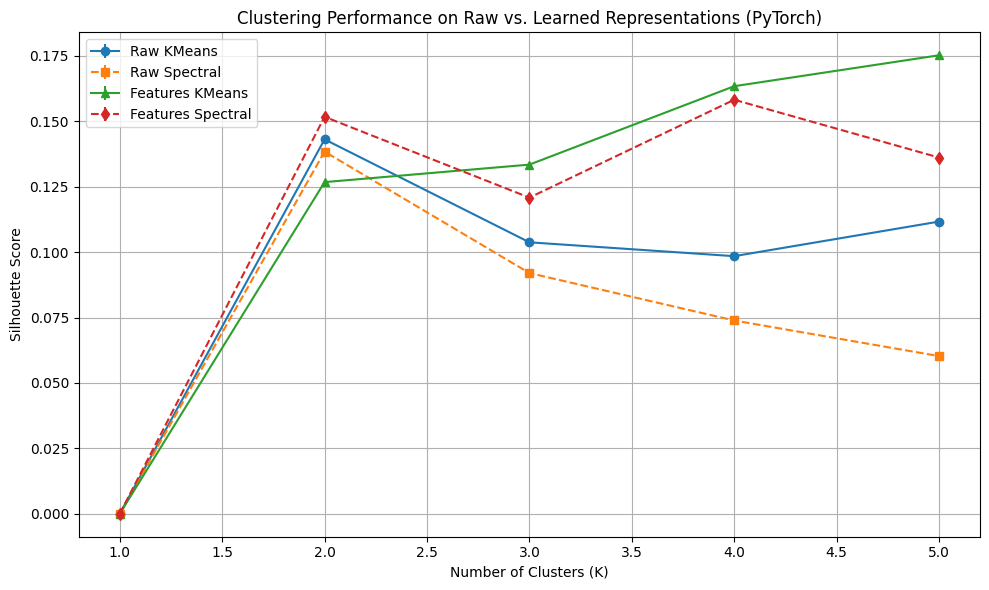

In [37]:
# Plot
plt.figure(figsize=(10, 6))
for label, vals, style in zip(
    ['Raw KMeans', 'Raw Spectral', 'Features KMeans', 'Features Spectral'],
    [results['raw_kmeans'], results['raw_spectral'], results['feat_kmeans'], results['feat_spectral']],
    ['o-', 's--', '^-', 'd--']
):
    means, stds = zip(*vals)
    plt.errorbar(ks, means, yerr=stds, label=label, fmt=style)

plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Clustering Performance on Raw vs. Learned Representations (PyTorch)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# <font color='blue'>Observations</font>
### 1. Structure of the Output: 
- The dictionary contains clustering performance results across different methods and data representations:'raw_kmeans', 'raw_spectral',
 'feat_kmeans', 'feat_spectral'
- Each list contains 5 tuples, one for each value of K = 1 to 5.
### 2. Key Concepts
- Silhouette Score (range: -1 to 1):
- Closer to 1 → dense and well-separated clusters (good).
- Near 0 is overlapping or unclear clusters. Negative is incorrect clustering.
- Standard Deviation tells how consistent the score is across 10 runs.
### 3. raw_kmeans - Clustering on raw pixel values using KMeans
- Moderate clustering quality at best.
- Low silhouette scores, even at best cluster size (K=2).
- Scores slightly improve with K=5.
- Standard deviation is almost 0 → results are consistent.
### 4. raw_spectral - Clustering on raw pixel values using Spectral Clustering:
- Slightly worse than raw KMeans.
- Score declines as K increases → Spectral struggles with raw data.
### 5. feat_kmeans - Clustering on CNN features using KMeans:
- Clear upward trend → learned features cluster better with higher K.
- Best performance: K=5, score ≈ 0.172 
### 6. feat_spectral - Clustering on CNN features using Spectral Clustering:
- Comparable to feat_kmeans, though slightly lower at K=5.
- Best performance at K=2–4.
- low std dev → stable results.
### 7. Summary of Insights in a table format below

| Representation	| Method	| Best K	| Best Score	| Comments	|
| --- | --- | --- |--- | --- |
| Raw Pixels | KMeans	| 2	| ~0.1431 | Weak clusters, some structure |
| Raw Pixels	| Spectral | 	2	| ~0.1384 | Weaker than KMeans overall |
| CNN Features |	KMeans	| 5	| ~0.1721	| Best overall performance |
| CNN Features	| Spectral	| 2–4	| ~0.1571	| Competitive, slightly lower than KMeans |




# <font color='blue'>Conclusion</font>
#### 1. CNN features are more clusterable than raw pixels — they create more compact, well-separated representations.
#### 2. KMeans on learned features gives the best and most consistent clustering performance.
#### 3. Spectral Clustering performs reasonably well but doesn’t surpass KMeans for this task.
#### 4. These results validate that feature learning via CNN improves unsupervised clustering.